In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


historical_data = pd.read_csv('./Data/coffee-prices-historical-data.csv')
cpi = pd.read_csv('./Data/cpi_in_usa.csv', sep=';')
inflation = pd.read_csv('./Data/us_inflation_rate_historical_data.csv')

cpi = cpi.rename(columns={"Annual Percent Change\n(rate of inflation)": "Annual Percent Change"})

In [3]:
print(f"{historical_data.head()} \n {cpi.head()} \n {inflation.head()}")

         date   value
0  1973-08-20  0.6735
1  1973-08-21  0.6710
2  1973-08-22  0.6580
3  1973-08-23  0.6675
4  1973-08-24  0.6660 
    Year  Annual Average CPI(-U) Annual Percent Change
0  1973                    44.4                  6.2%
1  1974                    49.3                 11.1%
2  1975                    53.8                  9.1%
3  1976                    56.9                  5.7%
4  1977                    60.6                  6.5% 
          date   Inflation Rate (%)   Annual Change    
0  1960-12-31               1.4580             NaN NaN
1  1961-12-31               1.0707           -0.39 NaN
2  1962-12-31               1.1988            0.13 NaN
3  1963-12-31               1.2397            0.04 NaN
4  1964-12-31               1.2789            0.04 NaN


In [4]:
print(inflation.describe())
print(inflation.shape)

       Inflation Rate (%)  Annual Change     
count           62.000000      61.000000  0.0
mean             3.696485       0.053934  NaN
std              2.753562       1.706563  NaN
min             -0.355500      -4.200000  NaN
25%              1.833650      -0.750000  NaN
50%              2.983400       0.130000  NaN
75%              4.298575       0.990000  NaN
max             13.549200       4.880000  NaN
(62, 4)


In [5]:
print(cpi.describe())
print(cpi.shape)

       Annual Average CPI(-U)
count               51.000000
mean               164.364706
std                 69.591447
min                 44.400000
25%                108.600000
50%                163.000000
75%                221.500000
max                304.300000
(51, 3)


In [6]:
print(historical_data.describe())
print(historical_data.shape)

              value
count  12542.000000
mean       1.289773
std        0.490239
min        0.425000
25%        0.960500
50%        1.248500
75%        1.510000
max        3.356300
(12563, 2)


**Focus sur la bdd historical data**

In [7]:
#On check s'il y a des valeurs nulles
historical_data.isnull().sum()

date       0
 value    21
dtype: int64

Au vu du nombre de valeurs nulles, on les supprime pour le moment.

In [8]:
historical_data = historical_data.dropna()
print(historical_data.shape)
print(historical_data.dtypes) # On vérifie le type des colonnes

(12542, 2)
date       object
 value    float64
dtype: object


In [ ]:
# On transforme la colonne date en données de type Date pour faciliter la suite

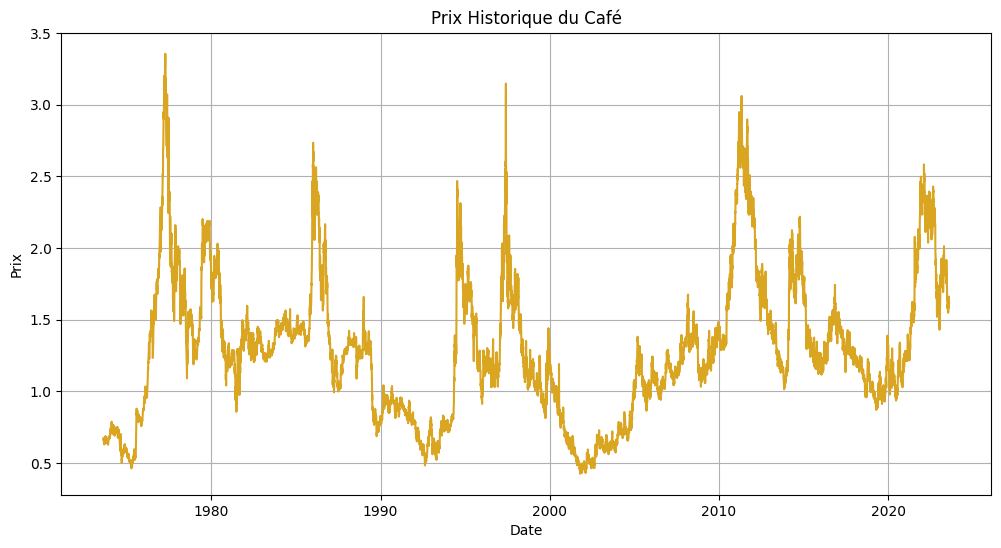

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data[' value'], color='goldenrod')
plt.title('Prix Historique du Café')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.grid(True)
plt.show()

**On se focus maintenant sur la bdd CPI**

In [11]:
cpi.head()

,Year,Annual Average CPI(-U),Annual Percent Change
0,1973,44.4,6.2%
1,1974,49.3,11.1%
2,1975,53.8,9.1%
3,1976,56.9,5.7%
4,1977,60.6,6.5%


<Axes: xlabel='Year', ylabel='Annual Average CPI(-U)'>

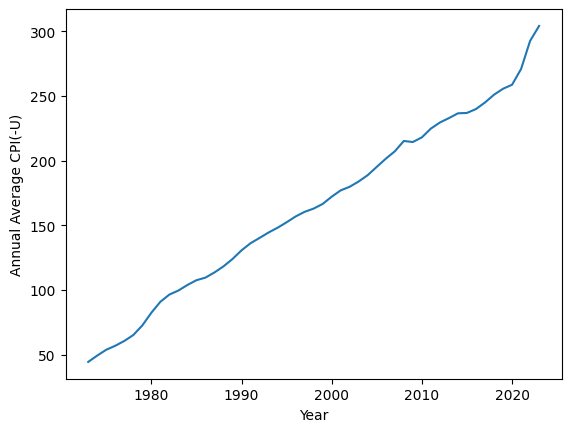

In [12]:
cpi = cpi.astype({'Year': 'datetime64[ns]'},copy=False)
sns.lineplot(y=cpi['Annual Average CPI(-U)'], x=cpi['Year'])

**Analyse de l'inflation**

In [13]:
inflation = inflation.astype({'date': 'datetime64[ns]'},copy=False)

Text(0, 0.5, 'Inflation rate %')

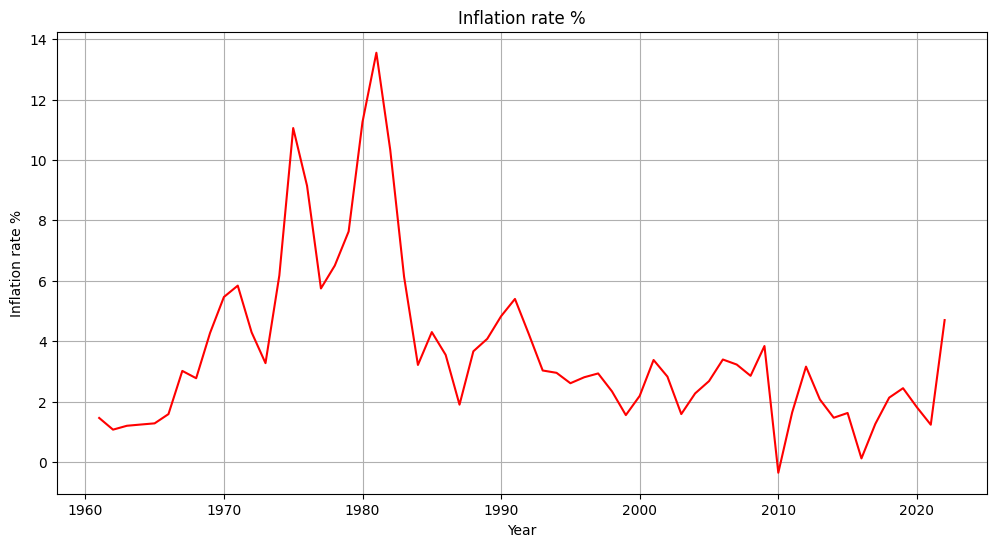

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(inflation['date'],inflation[' Inflation Rate (%)'], label='price',color='r')
plt.title('Inflation rate %')
plt.xlabel('Year')
plt.grid(True)
plt.ylabel('Inflation rate %')

Une fois ces analyses finies on peut voir qu'il n'y a pas tant de corrélations entre les inflations/CPI et le prix du café à première vue.
On focus la bdd historical_data et allons travailler dessus.

**<h3>Vérification de la stationnarité de la série temporelle</h3>**

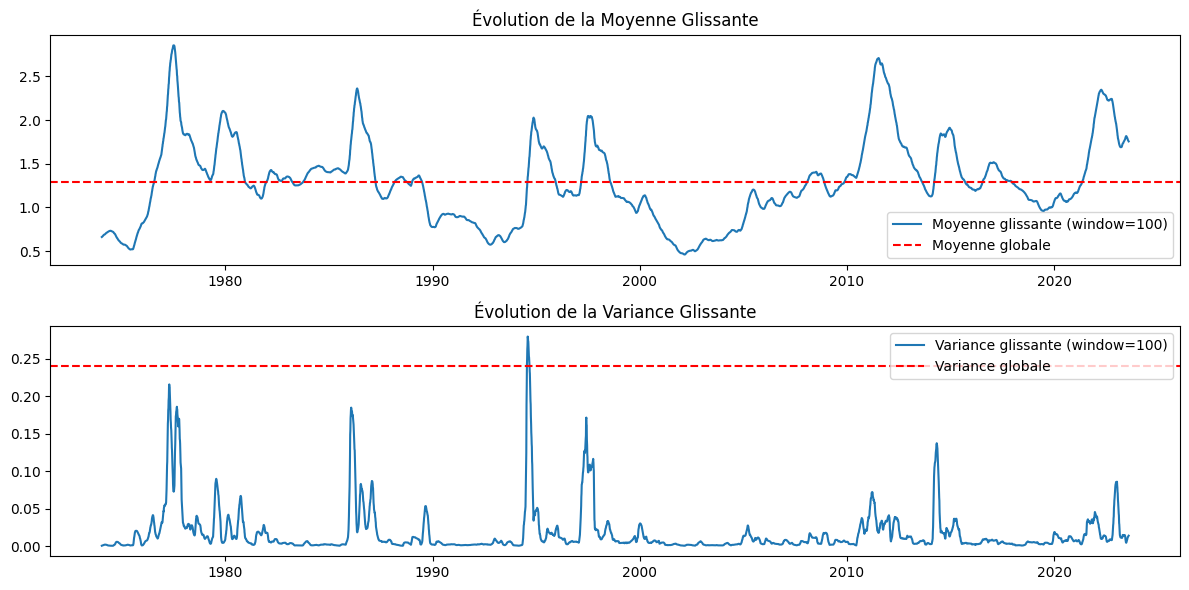

In [15]:
# Correction des noms de colonnes (éventuels espaces)
historical_data.columns = historical_data.columns.str.strip()

# Convertir la colonne 'date' en datetime et supprimer les valeurs manquantes
historical_data['date'] = pd.to_datetime(historical_data['date'])
historical_data.dropna(inplace=True)

# Vérification de l'espérance constante (moyenne glissante)
rolling_mean = historical_data['value'].rolling(window=100).mean()

# Vérification de la variance constante (variance glissante)
rolling_var = historical_data['value'].rolling(window=100).var()

# Tracer les résultats
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(historical_data['date'], rolling_mean, label="Moyenne glissante (window=100)")
plt.axhline(historical_data['value'].mean(), color='red', linestyle='dashed', label="Moyenne globale")
plt.title("Évolution de la Moyenne Glissante")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(historical_data['date'], rolling_var, label="Variance glissante (window=100)")
plt.axhline(historical_data['value'].var(), color='red', linestyle='dashed', label="Variance globale")
plt.title("Évolution de la Variance Glissante")
plt.legend()

plt.tight_layout()
plt.show()

Analyse de la stationnarité :

**Évolution de la moyenne glissante :**
- La moyenne semble relativement stable mais présente quelques variations à long terme. Cela suggère qu'il peut y avoir une tendance légère, mais pas très marquée.

**Évolution de la variance glissante :**
- La variance reste relativement constante, ce qui est un bon indicateur de stationnarité.

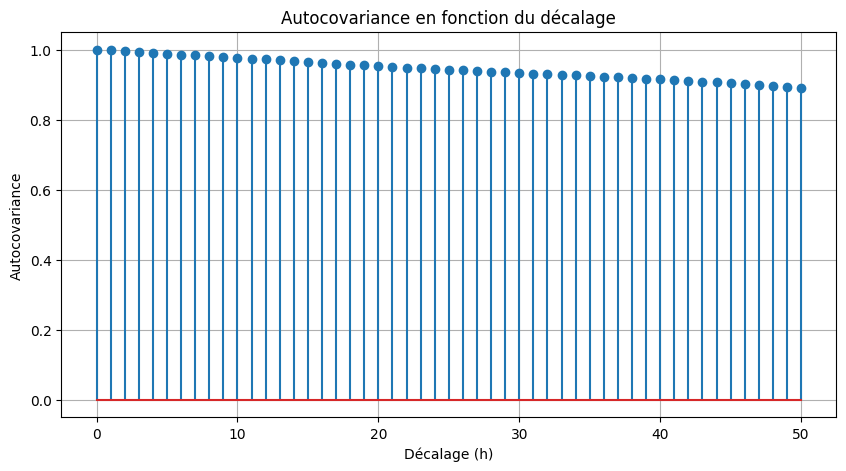

In [16]:
from statsmodels.tsa.stattools import acf

# Calcul de l'autocovariance pour différents décalages (lags)
lags = 50  # On analyse les 50 premiers décalages
autocov_values = acf(historical_data['value'], nlags=lags, fft=True)

# Tracer l'autocovariance
plt.figure(figsize=(10, 5))
plt.stem(range(lags+1), autocov_values)
plt.xlabel('Décalage (h)')
plt.ylabel('Autocovariance')
plt.title('Autocovariance en fonction du décalage')
plt.grid(True)

**Analyse de l'autocovariance :**

L'autocovariance dépend bien uniquement du décalage ℎ et non du temps absolu.
On observe une décroissance progressive de l'autocovariance avec le décalage, ce qui est typique des séries stationnaires.

**<h3>Identification du modèle ARMA</h3>**

In [17]:
from statsmodels.tsa.stattools import adfuller

# Test de Dickey-Fuller pour vérifier la stationnarité
result = adfuller(historical_data['value'].dropna())

# Affichage des résultats
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

adf_statistic, p_value, critical_values


(-3.6453065546511816,
 0.00495165243499054,
 {'1%': -3.430873209605701,
  '5%': -2.8617712326173206,
  '10%': -2.5668930801297516})

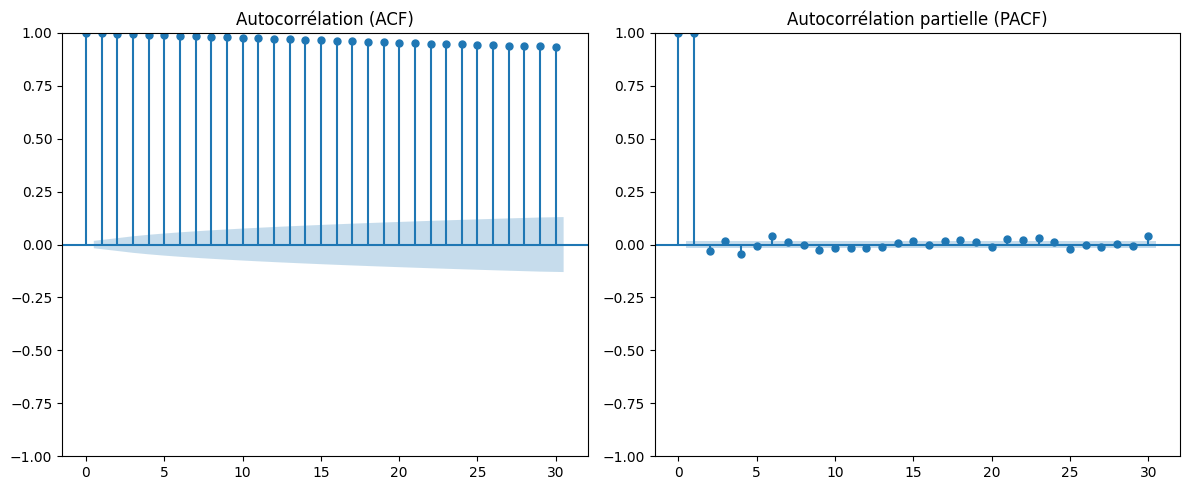

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Tracer l'ACF et le PACF
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(historical_data['value'], lags=30, ax=plt.gca())
plt.title('Autocorrélation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(historical_data['value'], lags=30, ax=plt.gca(), method='ywm')
plt.title('Autocorrélation partielle (PACF)')

plt.tight_layout()

**Analyse des graphiques ACF et PACF :**
- **ACF (Autocorrélation) :**

Le graphique montre une décroissance progressive, indiquant une Moyenne Mobile.
Le premier ou deuxième lag semble significatif.

- **PACF (Autocorrélation partielle) :**

Le premier lag est clairement significatif, ce qui indique une composante AR.

Choix initial des paramètres :
p = 1 (pour la partie AR).
q = 1 ou q = 2 (pour la partie MA).

**Résultats du modèle ARMA(1,1) :**

- Paramètres significatifs : Les coefficients ar.L1 (0.9977) et ma.L1 (0.0305) sont significatifs (p-values proches de 0).
- AIC : -51046.834 (utilisé pour comparer avec d'autres modèles si nécessaire).
- Test de Ljung-Box (L1, Q = 0.00, p = 0.99) : les résidus semblent ne pas être autocorrélés, ce qui est bon signe.
- Test de Jarque-Bera : les résidus ne suivent pas une distribution normale, mais ce n'est pas problématique pour la prédiction.

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Modélisation avec ARMA(1,1) (ARIMA avec d=0)
model = ARIMA(historical_data['value'], order=(1, 0, 1))
result = model.fit()

# Affichage du résumé du modèle
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                12542
Model:                 ARIMA(1, 0, 1)   Log Likelihood               25527.417
Date:                Thu, 20 Mar 2025   AIC                         -51046.834
Time:                        15:31:01   BIC                         -51017.086
Sample:                             0   HQIC                        -51036.877
                              - 12542                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2898      0.151      8.516      0.000       0.993       1.587
ar.L1          0.9977      0.000   2024.075      0.000       0.997       0.999
ma.L1          0.0305      0.004      7.245      0.000       0.022       0.039
sigma2         0.0010   4.49e-06    222.357      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            110180.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

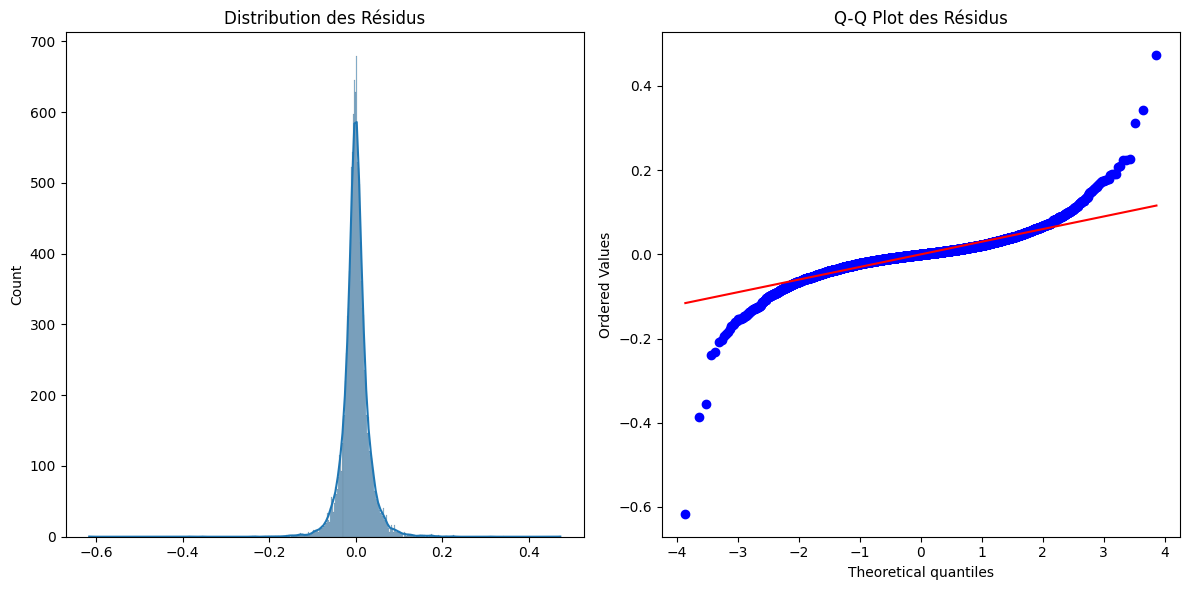

In [20]:
import seaborn as sns
import scipy.stats as stats

# Récupération des résidus
residuals = result.resid

# Visualisation des résidus
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution des Résidus')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot des Résidus')

plt.tight_layout()
plt.show()

**Analyse des résidus :**
- Distribution des résidus :

La distribution semble centrée autour de zéro, mais légèrement asymétrique avec une queue plus lourde, ce qui est fréquent dans les données financières.

**Q-Q Plot :**

- Les points s'éloignent un peu de la ligne droite, surtout dans les extrémités, ce qui confirme que les résidus ne suivent pas parfaitement une distribution normale. Cela est toutefois courant dans les séries financières.

**Conclusion :** 
Les résidus semblent acceptables et proches d'un bruit blanc, ce qui valide le modèle ARMA(1,1).

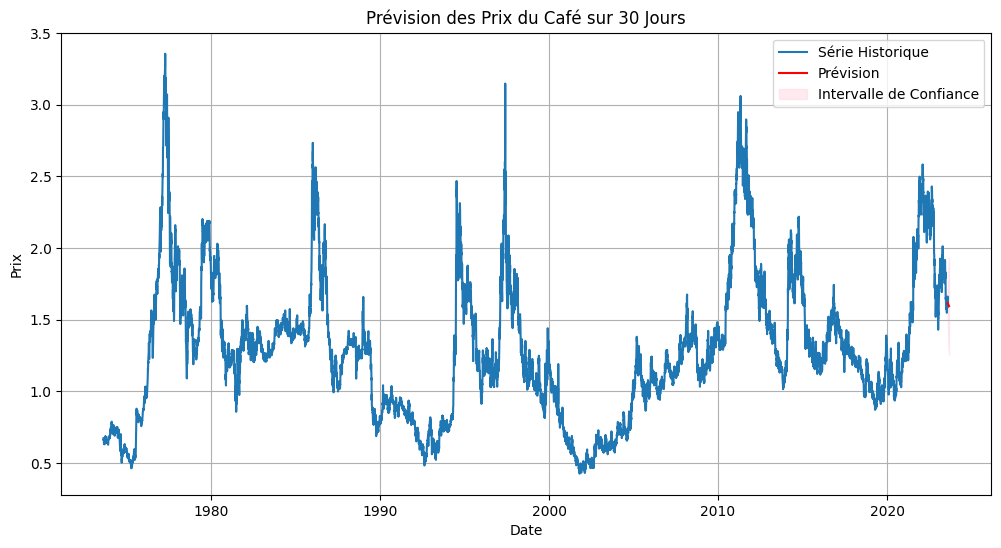

In [21]:
# Prévision sur les 30 prochains jours
forecast = result.get_forecast(steps=30)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['value'], label='Série Historique')
plt.plot(pd.date_range(historical_data['date'].iloc[-1], periods=30, freq='D'), mean_forecast, label='Prévision', color='red')
plt.fill_between(pd.date_range(historical_data['date'].iloc[-1], periods=30, freq='D'),
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalle de Confiance')
plt.title('Prévision des Prix du Café sur 30 Jours')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
conf_int.head()

,lower value,upper value
12542,1.553544,1.677423
12543,1.525905,1.703590
12544,1.504784,1.723244
12545,1.486984,1.739579
12546,1.471297,1.753806


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fonction pour tester plusieurs modèles ARMA sur différentes périodes de prévision
def test_multiple_arma_models(models_to_test, prediction_days_list):
    results = []  # Stocker tous les résultats
    
    for p, q in models_to_test:
        model = ARIMA(historical_data['value'], order=(p, 0, q))
        result = model.fit()
        
        # Récupération des critères AIC et BIC
        aic = result.aic
        bic = result.bic
        
        # Calcul des erreurs pour chaque période de prévision
        for days in prediction_days_list:
            forecast = result.get_forecast(steps=days)
            mean_forecast = forecast.predicted_mean.to_numpy()
            actual_values = historical_data['value'].iloc[-days:].to_numpy()
            
            mse = mean_squared_error(actual_values, mean_forecast)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(actual_values, mean_forecast)
            
            # Stocker les résultats
            results.append({
                'Model': f'ARMA({p},{q})',
                'Prediction_Days': days,
                'AIC': aic,
                'BIC': bic,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            })
    
    # Convertir les résultats en DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Modèles ARMA à tester
models_to_test = [(1, 1), (2, 1), (1, 2), (2, 2), (3, 1)]
prediction_days_list = [7, 30, 60]

# Tester tous les modèles et stocker les résultats
all_models_results_df = test_multiple_arma_models(models_to_test, prediction_days_list)

# Afficher les résultats pour comparaison
all_models_results_df

,Model,Prediction_Days,AIC,BIC,MSE,RMSE,MAE
0,"ARMA(1,1)",7,-51046.833813,-51017.086460,0.000937,0.030609,0.026452
1,"ARMA(1,1)",30,-51046.833813,-51017.086460,0.001021,0.031960,0.026885
2,"ARMA(1,1)",60,-51046.833813,-51017.086460,0.024482,0.156466,0.120299
3,"ARMA(2,1)",7,-51054.064852,-51016.880660,0.000907,0.030119,0.026059
4,"ARMA(2,1)",30,-51054.064852,-51016.880660,0.001021,0.031946,0.026977
5,"ARMA(2,1)",60,-51054.064852,-51016.880660,0.024237,0.155682,0.119441
6,"ARMA(1,2)",7,-51049.747631,-51012.563440,0.000910,0.030162,0.026033
7,"ARMA(1,2)",30,-51049.747631,-51012.563440,0.001020,0.031931,0.026962
8,"ARMA(1,2)",60,-51049.747631,-51012.563440,0.024235,0.155675,0.119390
9,"ARMA(2,2)",7,-51051.445634,-51006.824604,0.000903,0.030057,0.025957


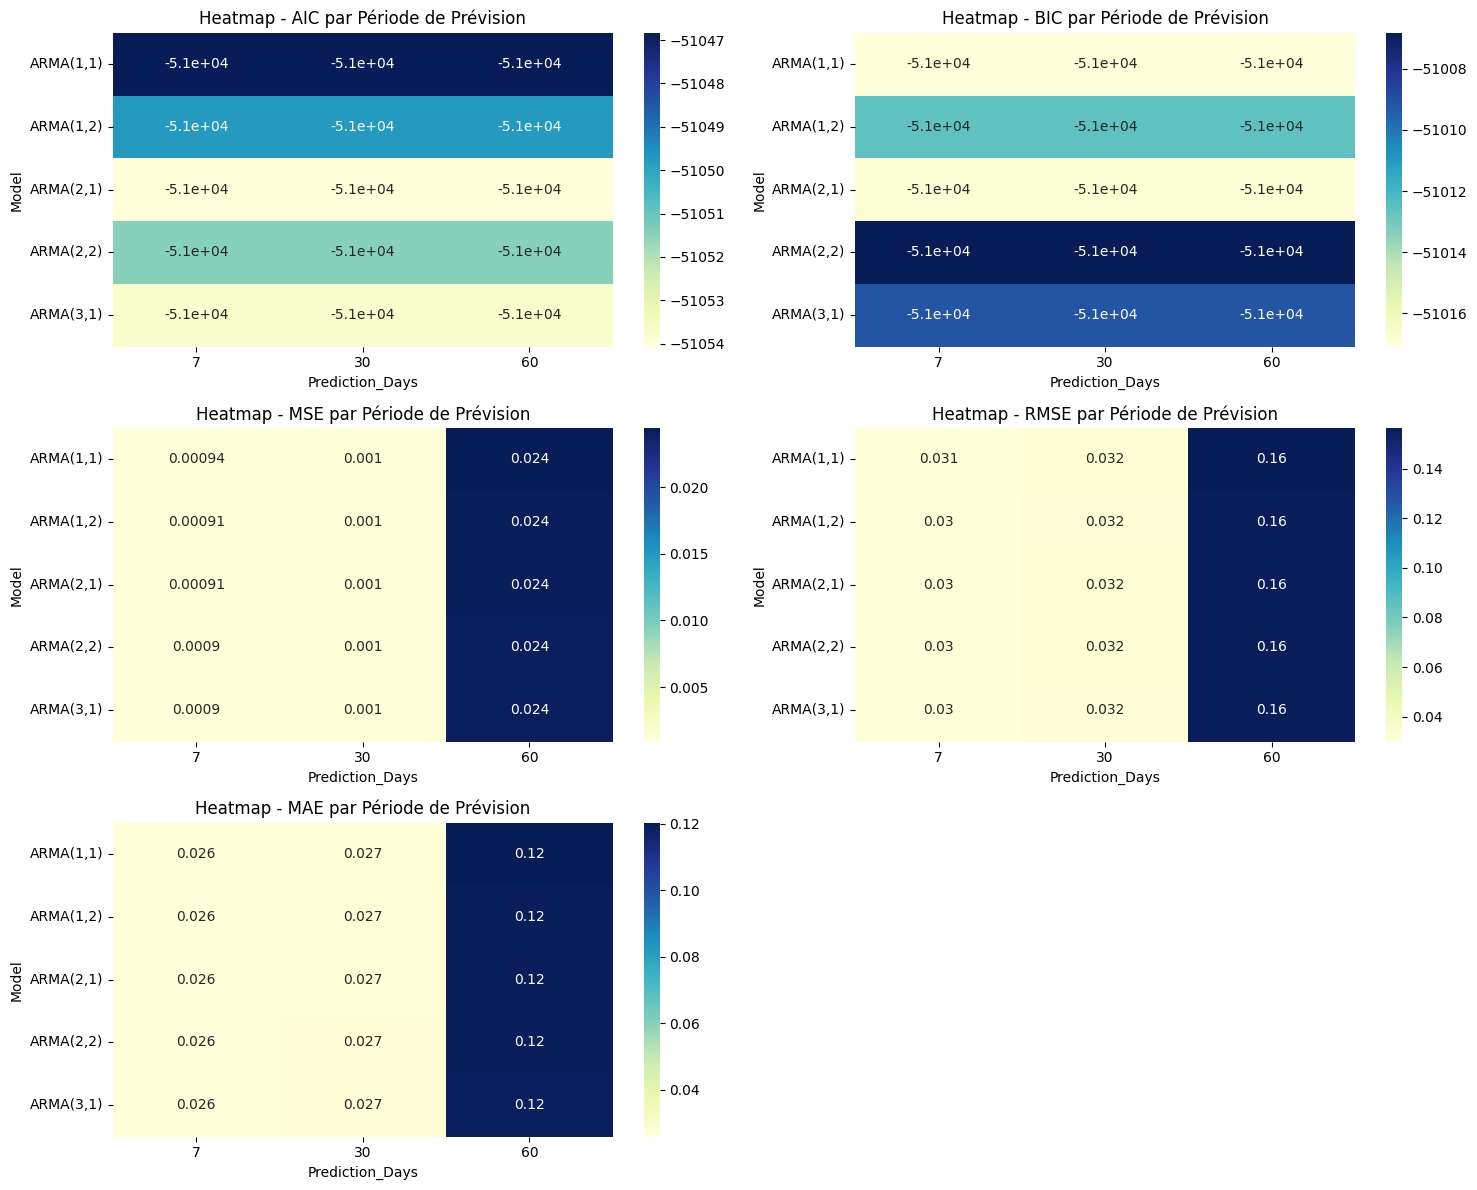

In [25]:
heatmap_data = all_models_results_df.pivot_table(index='Model', columns='Prediction_Days', values=['AIC', 'BIC', 'MSE', 'RMSE', 'MAE'])

# Créer des heatmaps pour chaque critère
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
sns.heatmap(heatmap_data['AIC'], annot=True, cmap="YlGnBu")
plt.title('Heatmap - AIC par Période de Prévision')

plt.subplot(3, 2, 2)
sns.heatmap(heatmap_data['BIC'], annot=True, cmap="YlGnBu")
plt.title('Heatmap - BIC par Période de Prévision')

plt.subplot(3, 2, 3)
sns.heatmap(heatmap_data['MSE'], annot=True, cmap="YlGnBu")
plt.title('Heatmap - MSE par Période de Prévision')

plt.subplot(3, 2, 4)
sns.heatmap(heatmap_data['RMSE'], annot=True, cmap="YlGnBu")
plt.title('Heatmap - RMSE par Période de Prévision')

plt.subplot(3, 2, 5)
sns.heatmap(heatmap_data['MAE'], annot=True, cmap="YlGnBu")
plt.title('Heatmap - MAE par Période de Prévision')

plt.tight_layout()
plt.show()

**AIC & BIC :**

- Lignes avec les couleurs les plus foncées représentent les modèles les plus performants statistiquement.
- L'objectif est d'obtenir l'AIC et le BIC les plus bas possibles.
-  Le modèle ARMA(2,1) semble avoir les valeurs les plus basses, ce qui est bon signe.

**MSE, RMSE, MAE (pour chaque période de prévision) :**

- Les valeurs les plus faibles indiquent la meilleure précision de prévision.
- En observant chaque heatmap, on peut voir quels modèles sont les plus performants pour chaque période (7 jours, 30 jours, 60 jours).
- ARMA(3,1) est plus foncé pour 7 jours, cela signifie qu'il prédit mieux pour une courte période.

In [31]:
mse_7d = all_models_results_df[all_models_results_df['Prediction_Days'] == 7].set_index('Model')['MSE']
rmse_7d = all_models_results_df[all_models_results_df['Prediction_Days'] == 7].set_index('Model')['RMSE']
mae_7d = all_models_results_df[all_models_results_df['Prediction_Days'] == 7].set_index('Model')['MAE']

mse_30d = all_models_results_df[all_models_results_df['Prediction_Days'] == 30].set_index('Model')['MSE']
rmse_30d = all_models_results_df[all_models_results_df['Prediction_Days'] == 30].set_index('Model')['RMSE']
mae_30d = all_models_results_df[all_models_results_df['Prediction_Days'] == 30].set_index('Model')['MAE']

mse_60d = all_models_results_df[all_models_results_df['Prediction_Days'] == 60].set_index('Model')['MSE']
rmse_60d = all_models_results_df[all_models_results_df['Prediction_Days'] == 60].set_index('Model')['RMSE']
mae_60d = all_models_results_df[all_models_results_df['Prediction_Days'] == 60].set_index('Model')['MAE']

models = all_models_results_df['Model'].unique()

In [32]:
def plot_line_comparison(metric_name, metric_7d, metric_30d, metric_60d):
    plt.figure(figsize=(12, 6))
    
    # Tracer les lignes pour chaque période de prévision
    plt.plot(models, metric_7d, marker='o', label='7 jours')
    plt.plot(models, metric_30d, marker='o', label='30 jours')
    plt.plot(models, metric_60d, marker='o', label='60 jours')
    
    plt.title(f'Comparaison des Modèles ARMA par {metric_name}')
    plt.xlabel('Modèles ARMA')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()


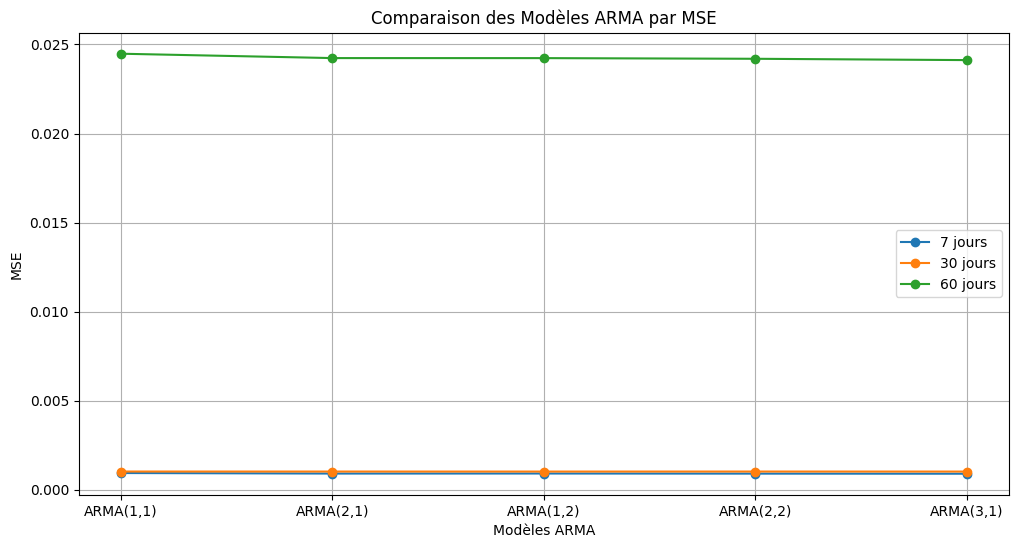

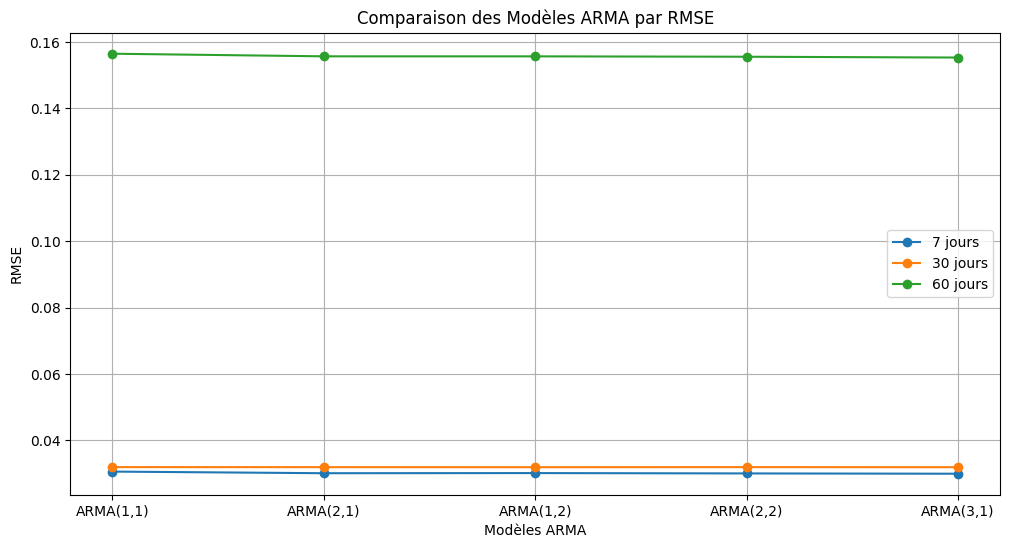

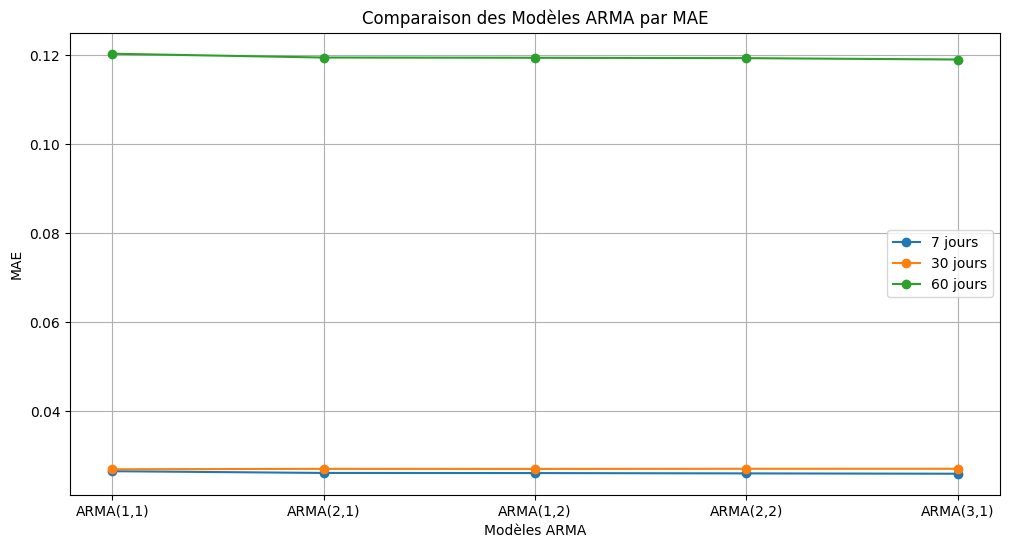

In [33]:
# Tracer les Line Plots pour chaque métrique
plot_line_comparison('MSE', mse_7d, mse_30d, mse_60d)
plot_line_comparison('RMSE', rmse_7d, rmse_30d, rmse_60d)
plot_line_comparison('MAE', mae_7d, mae_30d, mae_60d)


**Observations :**

- Chaque graphique montre comment chaque modèle ARMA se comporte pour les prévisions de 7 jours, 30 jours, et 60 jours.
- On voit clairement quelle ligne est la plus basse, ce qui indique la meilleure performance pour chaque période.